In [1]:
import pickle
import numpy as np
import pandas as pd
import itertools as it
from pathlib import Path
import matplotlib.pylab as plt
from lameg.util import get_files
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

In [3]:
def add_subplot_label(ax, label, x=-.21, y=1.225):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=26, va='top', ha='right')


In [5]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(c, r, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx, cmap=cmap)
    else:
        iw = ax.imshow(mx, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation")
        ax.set_xlabel("Simulation")
        ax.set_xticks([0,n_layers-1])
        ax.set_xticklabels(['S','D'])
        ax.set_yticks([0,n_layers-1])
        ax.set_yticklabels(['S','D'])
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw


def norm_res(mx):
    norm = np.zeros(mx.shape)
    for l in range(mx.shape[1]):
        normed = mx[:,l] - np.min(mx[:,l])
        norm[:,l] = normed
    return norm


def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[1]):
        peak = np.argmax(mx[:, l]) # here is the problem (you find peak in evaluated!)
        annot[peak,l] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks

In [ ]:
n_layers = 11
layers = np.arange(n_layers).astype(int)



In [7]:
snr_res = Path("../output/snr_simulations/")
single_snr_files = get_files(snr_res, "*.pickle")

fnms = np.array([[i] + i.stem.split("_") for i in single_snr_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "snr"]
single_df_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
single_df_files["matrix"] = None
single_df_files.vx = single_df_files.vx.apply(lambda x: eval(x))
single_df_files.snr = single_df_files.snr.apply(lambda x: eval(x))
mxs = []
for ix, row in single_df_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    single_df_files.at[ix, "matrix"] = output
    
vertices = single_df_files.vx.unique()
vertices.sort()
snrs = single_df_files.snr.unique()
snrs.sort()

single_matrices_all = {i: [] for i in snrs}

for vx in vertices:
    for snr_ix, snr in enumerate(snrs):
        row = single_df_files.loc[
            (single_df_files.vx == vx) &
            (single_df_files.snr == snr)
        ]
        mx = row.matrix.values[0]
        mx = norm_res(mx)
        single_matrices_all[snr].append(mx)

In [19]:
folder_path = Path("../output/mid_sd_iteration_2_source_snr")
all_files = get_files(folder_path, "*.pickle", strings=["mid_sd"])

df_files = {
    "filename": [],
    "snr": [],
    "base_vertex": [],
    "layers_used": [],
    "layerF":[],
    "layerF_abs":[]
}

for file_path in all_files:
    with open(file_path, "rb") as file:
        data = pickle.load(file)
    
    df_files["filename"].append(file_path)
    df_files["base_vertex"].append(data["base_vertex"])
    df_files["layers_used"].append(order_fix.index(data["layers_used"]))
    df_files["snr"].append(data["snr"])
    
    lFdata = None
    if len(data["layerF"].shape) == 2:
        lFdata = data["layerF"][0]
    else:
        lFdata = data["layerF"]
    
    df_files["layerF"].append(lFdata - np.min(lFdata))
    df_files["layerF_abs"].append(lFdata)
    
double_df = pd.DataFrame.from_dict(df_files)

order_ = [list(i) for i in list(it.product(list(np.arange(11)), [5]))]
order_fix = []
for i in order_:
    if np.unique(i).shape[0] == 1:
        order_fix.append([i[0]])
    else:
        order_fix.append(i)

n_layers = 11
layers = np.arange(n_layers).astype(int)

source_dist = np.zeros((n_layers, n_layers)).astype(np.object_)
source_dist[source_dist == 0] = None
for i in order_:
    source_dist[i[0], i[0]] = r"$\bullet$"
    source_dist[i[1], i[0]] = r"$\bullet$"
    
double_matrices_all = {i: [] for i in snrs}

for vx in vertices:
    for snr_ix, snr in enumerate(snrs):
        vecs=[]
        vecs_abs=[]
        for o in order_:
            mx = double_df.loc[
                    (double_df.base_vertex == vx) &
                    (double_df.snr == snr) &
                    (double_df.layers_used==o[0])
                ].layerF.to_list()[0]
            vecs.append(mx.reshape(-1,1))
        mx = np.hstack(vecs)
        double_matrices_all[snr].append(mx)
            

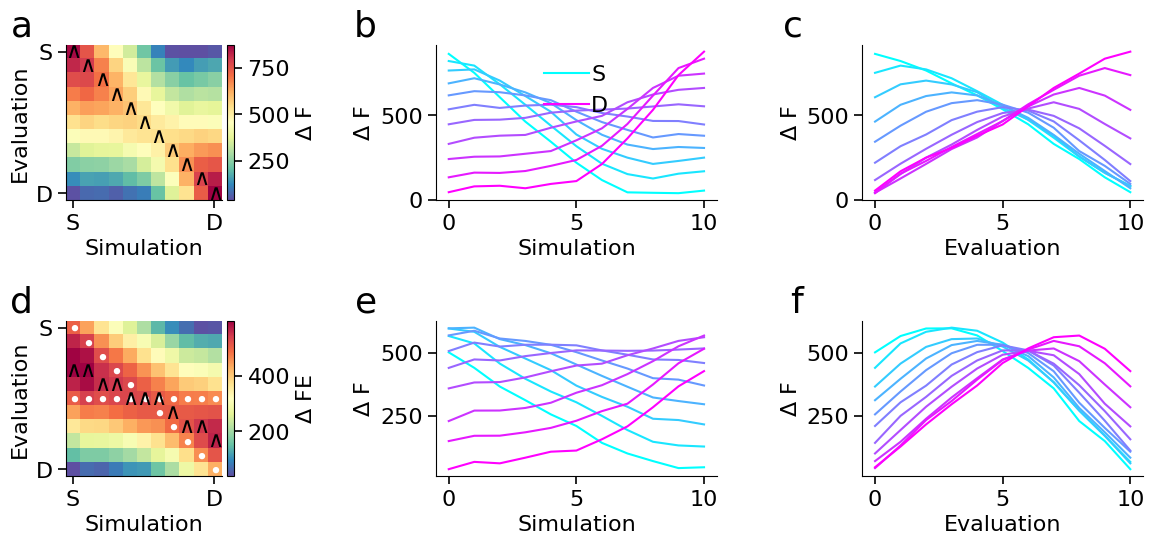

In [36]:
col_r = plt.cm.cool(np.linspace(0, 1, num=n_layers))

f, ax = plt.subplots(2, 3, figsize=(12, 6), facecolor="white")
snr=-20
m_mx = np.mean(single_matrices_all[snr], axis=0)
peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
iw = plot_mx(m_mx, ax=ax[0,0], labels=True, cbar=True, cbar_label=r"$\Delta$ F")
annotate_mx(iw, annot)
add_subplot_label(ax[0,0], 'a')
    
pmw = np.array(single_matrices_all[snr])
    
for ordr, ix in enumerate(range(n_layers)):
    if ordr==0:
        ax[0,1].plot(np.arange(n_layers), np.mean(pmw[:, ix, :], axis=0), c=col_r[ix,:], label='S')
    elif ordr==n_layers-1:
        ax[0,1].plot(np.arange(n_layers), np.mean(pmw[:, ix, :], axis=0), c=col_r[ix,:], label='D')
    else:
        ax[0,1].plot(np.arange(n_layers), np.mean(pmw[:, ix, :], axis=0), c=col_r[ix,:])
ax[0,1].set_xlabel('Simulation')
ax[0,1].set_ylabel(r"$\Delta$ F")
ax[0,1].legend()
add_subplot_label(ax[0,1], 'b')
       
for ordr, ix in enumerate(range(n_layers)):
    ax[0,2].plot(np.arange(n_layers), np.mean(pmw[:, :, ix], axis=0), c=col_r[ix,:])
ax[0,2].set_xlabel('Evaluation')
ax[0,2].set_ylabel(r"$\Delta$ F")
add_subplot_label(ax[0,2], 'c')
  
m_mx = np.mean(double_matrices_all[snr], axis=0)
peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
iw = plot_mx(m_mx, ax=ax[1,0], labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
annotate_mx(iw, source_dist, c="white")
annotate_mx(iw, annot)
add_subplot_label(ax[1,0], 'd')
    
pmw = np.array(double_matrices_all[snr])
    
for ordr, ix in enumerate(range(n_layers)):
    ax[1,1].plot(np.arange(n_layers), np.mean(pmw[:, ix, :], axis=0), c=col_r[ix,:])
ax[1,1].set_xlabel('Simulation')
ax[1,1].set_ylabel(r"$\Delta$ F")
add_subplot_label(ax[1,1], 'e')
        
for ordr, ix in enumerate(range(n_layers)):
    ax[1,2].plot(np.arange(n_layers), np.mean(pmw[:, :, ix], axis=0), c=col_r[ix,:])
ax[1,2].set_xlabel('Evaluation')
ax[1,2].set_ylabel(r"$\Delta$ F")
add_subplot_label(ax[1,2], 'f')

plt.tight_layout()
plt.savefig(f"figure_04_2_source.pdf")